# CDFS SWIRE master catalogue
## Checks and diagnostics

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
a03d5b3 (Wed Jul 5 12:19:29 2017 +0100) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

import locale
locale.setlocale(locale.LC_ALL, 'en_GB')

import os
import time
import itertools

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
from astropy import visualization as vis
import numpy as np
from matplotlib_venn import venn3

from herschelhelp_internal.masterlist import nb_compare_mags, nb_ccplots, nb_histograms

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))
#SUFFIX = "_20170627"

master_catalogue = Table.read("{}/master_catalogue_cdfs-swire{}.fits".format(OUT_DIR, SUFFIX))

## I - Summary of wavelength domains

In [4]:
flag_obs = master_catalogue['flag_optnir_obs']
flag_det = master_catalogue['flag_optnir_det']

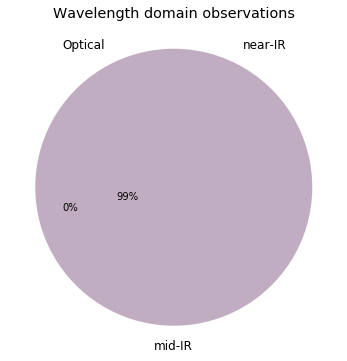

In [5]:
venn3(
    [
        np.sum(flag_obs == 4),
        np.sum(flag_obs == 2),
        np.sum(flag_obs == 6),
        np.sum(flag_obs == 1),
        np.sum(flag_obs == 5),
        np.sum(flag_obs == 3),
        np.sum(flag_obs == 7)
    ],
    set_labels=('Optical', 'near-IR', 'mid-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/len(flag_obs)))
)
plt.title("Wavelength domain observations");

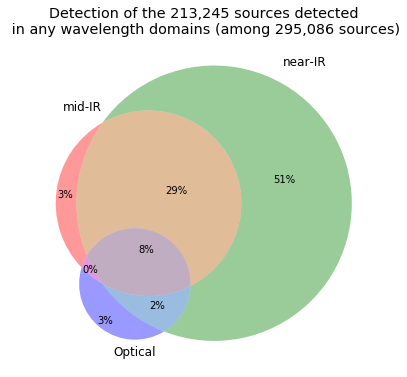

In [6]:
venn3(
    [
        np.sum(flag_det[flag_obs == 7] == 4),
        np.sum(flag_det[flag_obs == 7] == 2),
        np.sum(flag_det[flag_obs == 7] == 6),
        np.sum(flag_det[flag_obs == 7] == 1),
        np.sum(flag_det[flag_obs == 7] == 5),
        np.sum(flag_det[flag_obs == 7] == 3),
        np.sum(flag_det[flag_obs == 7] == 7)
    ],
    set_labels=('mid-IR', 'near-IR', 'Optical'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/np.sum(flag_det != 0)))
)
plt.title("Detection of the {} sources detected\n in any wavelength domains "
          "(among {} sources)".format(
              locale.format('%d', np.sum(flag_det != 0), grouping=True),
              locale.format('%d', len(flag_det), grouping=True)));

## II - Comparing magnitudes in similar filters

The master list if composed of several catalogues containing magnitudes in similar filters on different instruments. We are comparing the magnitudes in these corresponding filters.

In [9]:
u_bands = ["ATLAS u", "COMBO uj"]
g_bands = ["ATLAS g", "PS1 g", ]
r_bands = ["ATLAS r", "PS1 r"]
i_bands = ["ATLAS i", "PS1 i"]
z_bands = ["ATLAS z", "PS1 z"]
y_bands = ["VIDEO y", "VHS y"]

### II.a - Comparing depths

We compare the histograms of the total aperture magnitudes of similar bands.

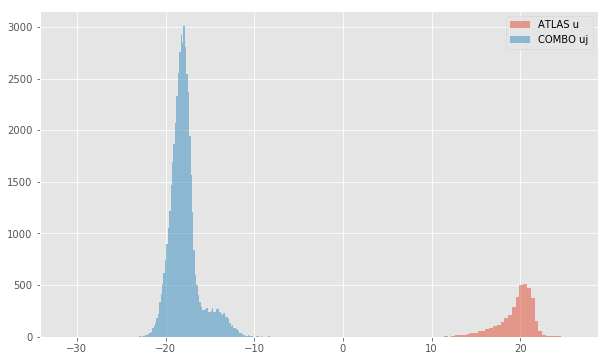

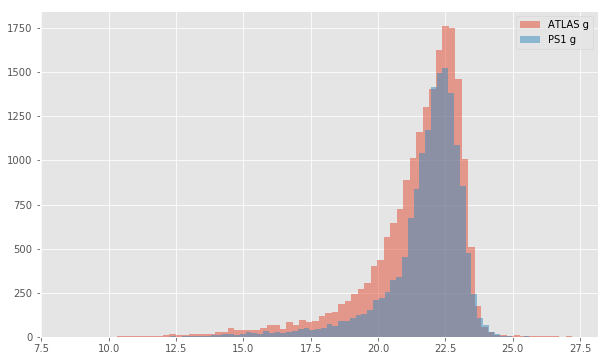

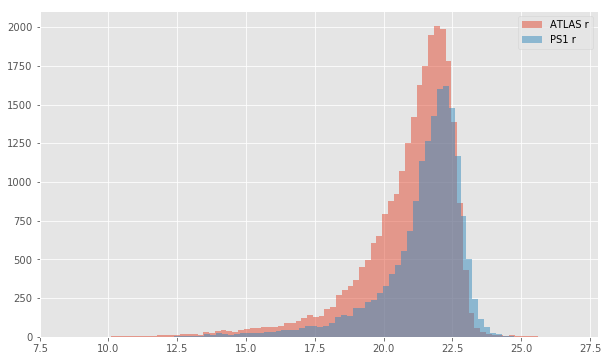

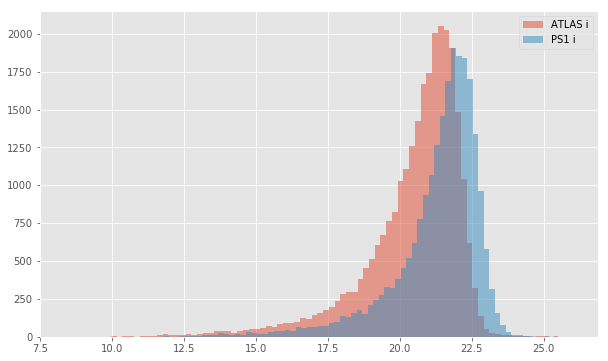

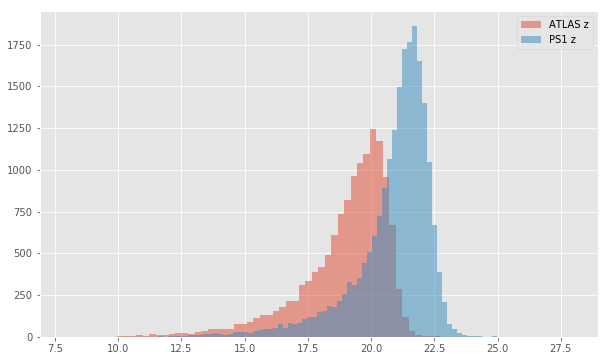

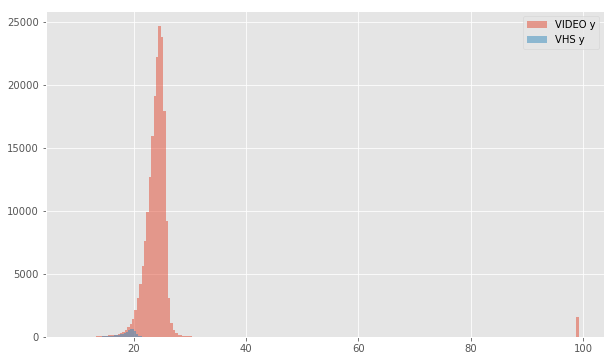

In [10]:
for bands in [u_bands, g_bands, r_bands, i_bands, z_bands, y_bands]:
    colnames = ["m_{}".format(band.replace(" ", "_").lower()) for band in bands]
    nb_histograms(master_catalogue, colnames, bands)

### II.b - Comparing magnitudes

We compare one to one each magnitude in similar bands.

In [11]:
for band_of_a_kind in [u_bands, g_bands, r_bands, i_bands, z_bands, y_bands]:
    for band1, band2 in itertools.combinations(band_of_a_kind, 2):
        
        basecol1, basecol2 = band1.replace(" ", "_").lower(), band2.replace(" ", "_").lower()
        
        col1, col2 = "m_ap_{}".format(basecol1), "m_ap_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (aperture)".format(band1), "{} (aperture)".format(band2)))
        
        col1, col2 = "m_{}".format(basecol1), "m_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (total)".format(band1), "{} (total)".format(band2)))

ValueError: zero-size array to reduction operation minimum which has no identity

## III - Comparing magnitudes to reference bands

Cross-match the master list to SDSS and 2MASS to compare its magnitudes to SDSS and 2MASS ones.

In [ ]:
master_catalogue_coords = SkyCoord(master_catalogue['ra'], master_catalogue['dec'])

### III.a - Comparing u, g, r, i, and z bands to SDSS

The catalogue is cross-matched to SDSS-DR13 withing 0.2 arcsecond. 

We compare the u, g, r, i, and z magnitudes to those from SDSS using `fiberMag` for the aperture magnitude and `petroMag`  for the total magnitude.

In [ ]:
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_CDFS-SWIRE.fits")
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)

idx, d2d, _ = sdss_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

sdss = sdss[mask]
ml_sdss_idx = idx[mask]

In [ ]:
for band_of_a_kind in [u_bands, g_bands, r_bands, i_bands, z_bands]:
    for band in band_of_a_kind:
        
        sdss_mag_ap = sdss["fiberMag_{}".format(band[-1])]
        master_cat_mag_ap = master_catalogue["m_ap_{}".format(band.replace(" ", "_").lower())][ml_sdss_idx]
    
        nb_compare_mags(sdss_mag_ap, master_cat_mag_ap,
                        labels=("SDSS {} (fiberMag)".format(band[-1]), "{} (aperture)".format(band)))
    
        sdss_mag_tot = sdss["petroMag_{}".format(band[-1])]
        master_cat_mag_tot = master_catalogue["m_ap_{}".format(band.replace(" ", "_").lower())][ml_sdss_idx]
        
        nb_compare_mags(sdss_mag_ap, master_cat_mag_ap,
                        labels=("SDSS {} (petroMag)".format(band[-1]), "{} (total)".format(band)))

### III.b - Comparing J and K bands to 2MASS

The catalogue is cross-matched to 2MASS-PSC withing 0.2 arcsecond. We compare the UKIDSS total J and K magnitudes to those from 2MASS.

The 2MASS magnitudes are “*Vega-like*” and we have to convert them to AB magnitudes using the zero points provided on [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html):

| Band | Fν - 0 mag (Jy) |
|------|-----------------|
| J    | 1594            |
| H    | 1024            |
| Ks   | 666.7           |

In addition, UKIDSS uses a K band whereas 2MASS uses a Ks (“short”) band, [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4b.html) give a correction to convert the K band in a Ks band with the formula:

$$K_{s(2MASS)} = K_{UKIRT} + 0.003 + 0.004 * (J−K)_{UKIRT}$$

In [ ]:
# The AB zero point is 3631 Jy
j_2mass_to_ab = 2.5 * np.log10(3631/1595)
k_2mass_to_ab = 2.5 * np.log10(3631/666.7)

In [ ]:
twomass = Table.read("../../dmu0/dmu0_2MASS-point-sources/data/2MASS-PSC_CDFS-SWIRE.fits")
twomass_coords = SkyCoord(twomass['raj2000'], twomass['dej2000'])

idx, d2d, _ = twomass_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

twomass = twomass[mask]
ml_twomass_idx = idx[mask]

In [ ]:
nb_compare_mags(twomass['jmag'] + j_2mass_to_ab, master_catalogue['m_video_j'][ml_twomass_idx],
                labels=("2MASS J", "VIDEO J (total)"))

In [ ]:
ukidss_ks_like = master_catalogue['m_video_k'] + 0.003 + 0.004 * (
    master_catalogue['m_video_j'] - master_catalogue['m_video_k'])
nb_compare_mags(twomass['kmag'] + k_2mass_to_ab, ukidss_ks_like[ml_twomass_idx],
                labels=("2MASS Ks", "VIDEO Ks-like (total)"))

## IV - Comparing aperture magnitudes to total ones.

In [ ]:
nb_ccplots(
    master_catalogue['m_ps1_r'],
    master_catalogue['m_ap_ps1_r'] - master_catalogue['m_ps1_r'],
    "r total magnitude (PanSTARRS)", "r aperture mag - total mag (PanSTARRS)",
    master_catalogue["stellarity"],
    invert_x=True
)

## V - Color-color and magnitude-color plots

In [ ]:
nb_ccplots(
    master_catalogue['m_ps1_g'] - master_catalogue['m_ps1_i'],
    master_catalogue['m_video_j'] - master_catalogue['m_video_k'],
    "g - i (PanSTARRS)", "J - K (VIDEO)",
    master_catalogue["stellarity"]
)

In [ ]:
nb_ccplots(
    master_catalogue['m_ps1_i'] - master_catalogue['m_irac1'],
    master_catalogue['m_ps1_g'] - master_catalogue['m_ps1_i'],
    "PanSTARRS i - IRAC1", "g - i (PanSTARRS)",
    master_catalogue["stellarity"]
)

In [ ]:
nb_ccplots(
    master_catalogue['m_atlas_u'] - master_catalogue['m_atlas_g'],
    master_catalogue['m_atlas_g'] - master_catalogue['m_atlas_r'],
    "u - g (ATLAS)", "g - r (ATLAS)",
    master_catalogue["stellarity"]
)

In [ ]:
nb_ccplots(
    master_catalogue['m_video_j'] - master_catalogue['m_video_k'],
    master_catalogue['m_ps1_g'] - master_catalogue['m_video_j'],
    "J - K (VIDEO)", "g - J (PanSTARRS, VIDEO)",
    master_catalogue["stellarity"]
)

In [ ]:
nb_ccplots(
    master_catalogue['m_ps1_i'] - master_catalogue['m_ps1_z'],
    master_catalogue['m_ps1_z'] - master_catalogue['m_video_j'],
    "i - z (PanSTARRS)", "z - J (PanSTARRS, VIDEO)",
    master_catalogue["stellarity"]
)

In [ ]:
nb_ccplots(
    master_catalogue['m_irac3'] - master_catalogue['m_irac4'],
    master_catalogue['m_irac1'] - master_catalogue['m_irac2'],
    "IRAC3 - IRAC4", "IRAC1 - IRAC2",
    master_catalogue["stellarity"]
)